In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\osaz001\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5131 - loss: 0.2501 - val_accuracy: 0.5396 - val_loss: 0.2481
Epoch 2/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5337 - loss: 0.2485 - val_accuracy: 0.5413 - val_loss: 0.2476
Epoch 3/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5408 - loss: 0.2476 - val_accuracy: 0.5495 - val_loss: 0.2465
Epoch 4/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5427 - loss: 0.2472 - val_accuracy: 0.5522 - val_loss: 0.2462
Epoch 5/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5489 - loss: 0.2462 - val_accuracy: 0.5532 - val_loss: 0.2458
Restoring model weights from the end of the best epoch: 3.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_lea

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 917us/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5168457971520564
Confusion Matrix:
[[58794 40478]
 [53610 41855]]
Precision: 50.836238203393535
Recall: 

In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [9]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [10]:


"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)"""


"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):\n\n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        \n        # Normalization factor to ensure absolute sum of values is 1\n        num_assets = len(assets)\n        if num_assets > 0:\n            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets\n\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\n\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test

In [11]:


def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):
    volatilities = calculate_annualized_volatility(df_read)

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)

        if start_date in volatilities.index:
            if portfolio_type == 'best':
                # Get volatilities for the assets at the start date
                asset_vols = volatilities.loc[start_date, assets].dropna()
                if not asset_vols.empty:
                    weights = 1 / asset_vols
                    total_weight = weights.sum()
                    normalized_weights = weights / total_weight  # Normalize weights
                    #estimated por vol ska vara här
                    
                    # Assign weights to assets in the DataFrame
                    for asset, weight in normalized_weights.items():
                        if asset in df.columns:
                            df.loc[start_date:end_date, asset] = weight
            else:
                num_assets = len(assets)
                if num_assets > 0:
                    value = -1 / num_assets
                    for asset in assets:
                        if asset in df.columns:
                            df.loc[start_date:end_date, asset] = value
                            

portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

   
    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [12]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [82]:
def calculate_daily_portfolio_volatility(weights, returns):
    # This will store the daily portfolio volatility
    daily_volatility = pd.Series(index=returns.index)
    
    # Loop through each day in the returns DataFrame
    for date in returns.index:
        # Take the weights for the current day
        current_weights = weights.loc[date]
        
        # Compute the covariance matrix up to the current day
        cov_matrix = returns.loc[:date].cov()
        
        # Ensure the covariance matrix and weights are aligned in order
        aligned_weights = current_weights.reindex(cov_matrix.columns).fillna(0)
        
        # Calculate the portfolio variance for the current day
        if not cov_matrix.empty and aligned_weights.isna().sum() != len(aligned_weights):
            portfolio_variance = np.dot(aligned_weights.T, np.dot(cov_matrix, aligned_weights))
            # Calculate the volatility (square root of variance)
            portfolio_volatility = np.sqrt(portfolio_variance)
            daily_volatility.loc[date] = portfolio_volatility
        else:
            daily_volatility.loc[date] = np.nan

    return daily_volatility


In [83]:
daily_volatility = calculate_daily_portfolio_volatility(xgb_weights, xgb_returns)


c:\appl\ipykernel_14092\986622745.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  daily_volatility = pd.Series(index=returns.index)
c:\appl\Anaconda3\lib\site-packages\pandas\core\frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\appl\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\appl\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [89]:
leverage_factor = determine_leverage_factor(daily_volatility)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [13]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [14]:
xgb_trade_volume.sum()

33740

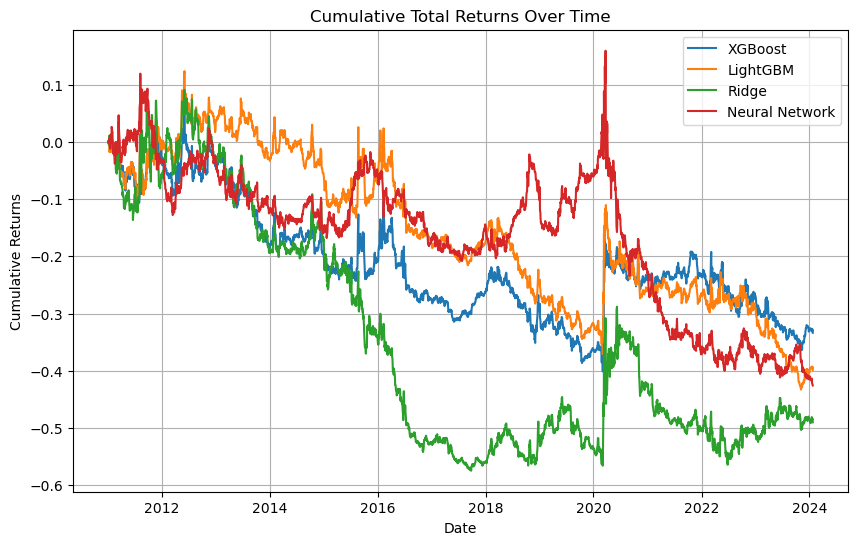

In [15]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [16]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
33740


LightGBM trade volume:
32587


Ridge trade volume:
34626


Neural Network trade volume:
34853




In [17]:
ridge_metrics = financial_metrics(ridge_total_returns)
lgb_metrics = financial_metrics(lgb_total_returns)
xgb_metrics = financial_metrics(xgb_total_returns)
NN_metrics = financial_metrics(NN_total_returns)

In [18]:
print("Ridge metrics:")
print(ridge_metrics)
print("\n")
print("LightGBM metrics:")
print(lgb_metrics)
print("\n")
print("XGBoost metrics:")
print(xgb_metrics)
print("\n")
print("Neural Network metrics:")
print(NN_metrics)


Ridge metrics:
{'Average Yearly Return': -0.03311892197676517, 'Average Yearly Standard Deviation': 0.18742389622358369, 'Sharpe Ratio': -0.17670597316607162, 'Max Drawdown': -8.929855920276147, 'Volatility': 0.18742389622358369, 'Calmar Ratio': -0.0037087857040968924, 'Skewness': 1.2373361981251139, 'Kurtosis': 33.23926440115732}


LightGBM metrics:
{'Average Yearly Return': -0.0307754372331427, 'Average Yearly Standard Deviation': 0.12226174337961207, 'Sharpe Ratio': -0.25171763776987577, 'Max Drawdown': -7.96060287576172, 'Volatility': 0.12226174337961207, 'Calmar Ratio': -0.003865968157618705, 'Skewness': 2.306184449246648, 'Kurtosis': 35.39544280365372}


XGBoost metrics:
{'Average Yearly Return': -0.022610668634444102, 'Average Yearly Standard Deviation': 0.12601582575737305, 'Sharpe Ratio': -0.17942721478473647, 'Max Drawdown': -8.242700678507205, 'Volatility': 0.12601582575737305, 'Calmar Ratio': -0.0027431141219771927, 'Skewness': 2.165515607142032, 'Kurtosis': 36.280440879276

In [25]:
%reload_ext autoreload
%autoreload 2



In [36]:


def update_portfolio_with_volatility_control(df, portfolios, returns_df, hold_days, portfolio_type, target_volatility=0.10):
    volatilities = calculate_annualized_volatility(returns_df)
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)

        # Assuming returns_df already filtered for relevant assets
        past_returns = returns_df.loc[start_date-pd.DateOffset(days=365):start_date, assets]
        if start_date in df.index:
            asset_vols = volatilities.loc[start_date, assets].dropna()
            # Calculate weights based on inverse volatility
            if not asset_vols.empty:
                weights = 1 / asset_vols
                normalized_weights = weights / weights.sum()

                # Calculate portfolio volatility and adjust for target
                portfolio_volatility = calculate_portfolio_volatility(normalized_weights, past_returns)
                leverage_factor = determine_leverage_factor(portfolio_volatility, target_volatility)
                adjusted_weights = apply_leverage(normalized_weights, leverage_factor)

                # Apply weights based on portfolio_type
                 
                if portfolio_type == 'best': 
                    sign = 1
                else: 
                    -1
                for asset, weight in adjusted_weights.items():
                    df.loc[start_date:end_date, asset] = weight * sign


model_dfs_new = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


portfolios_best_new = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst_new = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best_new[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst_new[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_portfolio_with_volatility_control(model_dfs_new[name], portfolios_best_new[name], df_read, target_days,portfolio_type='best' , target_volatility=0.10)
    update_portfolio_with_volatility_control(model_dfs_new[name], portfolios_worst_new[name], df_read, target_days, portfolio_type='worst', target_volatility=0.10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [37]:
xgb_weights_new = model_dfs_new['xgb']
lgb_weights_new = model_dfs_new['lgb']
ridge_weights_new = model_dfs_new['ridge']
NN_weights_new = model_dfs_new['NN']




xgb_returns_new = xgb_weights_new*df_2_read
lgb_returns_new = lgb_weights_new*df_2_read
ridge_returns_new = ridge_weights_new*df_2_read
NN_returns_new = NN_weights_new*df_2_read


In [38]:
xgb_total_returns_new = xgb_returns_new.sum(axis=1)
lgb_total_returns_new = lgb_returns_new.sum(axis=1)
ridge_total_returns_new = ridge_returns_new.sum(axis=1)
NN_total_returns_new = NN_returns_new.sum(axis=1)

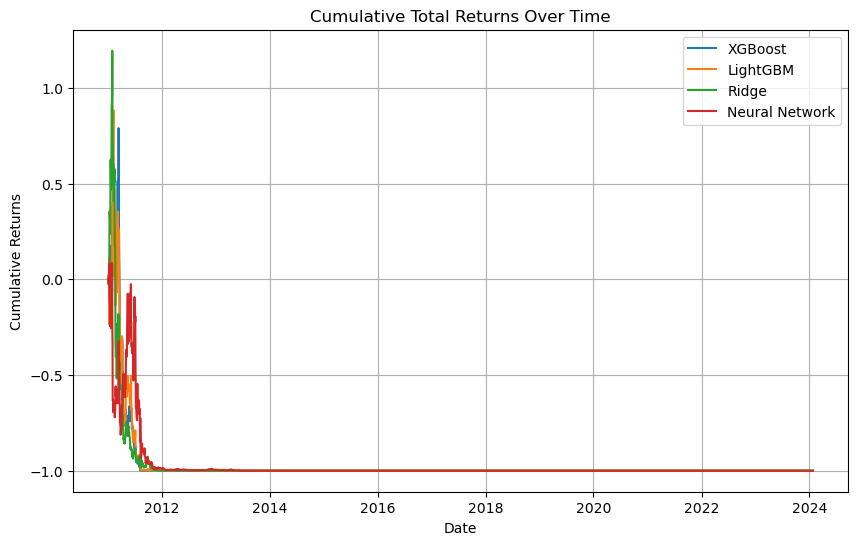

In [39]:
# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns_new = (1 + xgb_total_returns_new).cumprod() - 1
lgb_cumulative_total_returns_new = (1 + lgb_total_returns_new).cumprod() - 1
ridge_cumulative_total_returns_new = (1 + ridge_total_returns_new).cumprod() - 1
NN_cumulative_total_returns_new = (1 + NN_total_returns_new).cumprod() - 1

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns_new, label='XGBoost')
plt.plot(lgb_cumulative_total_returns_new, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_new, label='Ridge')
plt.plot(NN_cumulative_total_returns_new, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()